# DNN-Based DDoS Anomaly Detection in the Network Data Plane

In this 4-part notebook series, we show how a quantized neural network (QNN) can be trained to classify packets as belonging to DDoS (malicious) or regular (benign) network traffic flows. The model is trained with quantized weights and activations, and we use the [Brevitas](https://github.com/Xilinx/brevitas) framework to train the QNN. The model is then converted into an FPGA-friendly RTL implementation for high-throughput inference, which can be integrated with a packet-processing pipeline in the network data plane.

This notebook series is composed of 4 parts. Below is a brief summary of what each part covers.

[Part 1](./1-train.ipynb): How to use Brevitas to train a quantized neural network for our target application, which is classifying packets as belonging to malicious/DDoS or benign/normal network traffic flows. The output trained model at the end of this part is a pure software implementation, i.e. it cannot be converted to a custom RTL FINN model to run on an FPGA just yet.

[Part 2](./2-prepare.ipynb): This notebook focuses on taking the output software model from the previous part and preparing it for hardware-friendly implementation using the FINN framework. The notebook describes the steps taken to "surgery" the software model in order for hardware generation via FINN. We also verify that all the changes made to the software model in this notebook DO NOT affect the output predictions in the "surgeried" model.

[Part 3](./3-build.ipynb): In this notebook, we use the FINN framework to build the custom RTL accelerator for our target model. FINN can generate a variety of RTL accelerators, and this notebook covers some build configuration parameters that influence these outputs.

[Part 4](./4-verify.ipynb): The generated hardware is simulated using cycle-accurate RTL simulation tools, and its outputs are compared against the original software-only model trained in part one. The output model from this step is now ready to be integrated into a larger FPGA design, which in this context is a packet-processing network data plane pipeline designed for identifying anomalous DDoS flows from benign flows.

This tutorial series is a supplement to our demo paper presented at EuroP4 2023 workshop, titled [Enabling DNN Inference in the Network Data Plane](https://dl.acm.org/doi/10.1145/3630047.3630191). You can cite our work

# Motivation: Data Plane AI

Programmable network devices, such as SmartNICs (e.g. AMD Alveo SmartNICs), DPUs (e.g. AMD Pensando DPU), and programmable switches (e.g. Intel Tofino), are gaining popularity as they enable faster pace of innovation and more customisability for the end-user. Vendors have also adopted this trend, supporting languages such as P4 (e.g. Pensando and Tofino are P4-programmable) and eBPF (e.g. eBPF offload to Netronome FPCs), which has inspired network engineers to test and implement many new interesting use-cases in the network data plane, such as traffic classification, in-network consensus, in-network DNS, and more.

Modern machine learning methods, such as deep neural networks (DNNs), have had a profound impact on many application domains, most notably on computer vision and natural language processing. As expected, there is a long-tail of applications that can benefit from modern DNNs, and networking applications are not an exception. There is an increased interest in bringing more intelligence to networking applications, and hence a strong demand to enable DNN inference in the network data plane, often referred to as **Data Plane AI**.

However, in order to enable Data Plane AI, the DNN inference accelerator needs to be able to handle the challenging high data-rate environment of the network data plane. Furthermore, programmable network devices either have limited or unsuitable compute resources for DNNs in the data plane (extraction of features and/or execution of DNN model). Hence, end-users often fall back to executing DNN-based inference in the control plane, which is not suitable for low-latency per-packet operations at high line-rates. The figure below shows the high-level architectural motivations behind this work.

<div style="text-align:center">
    <img src="motivation_arch.png" alt="Motivation architecture" width="75%"/>
</div>

Here, we only show the RX datapath of a hypothetical networking device that has an FPGA fabric for mapping FINN inference engine designs to. The programmable packet processor can compute features and issue inference requests to the FINN accelerator, which computes the output using weights that were trained offline, and feeds the prediction back into the packet processor. The packet processor can then take this prediction result and use it to make packet/flow forwarding decisions in the data plane. In order to enable this vision, ideally, the inference engine should be capable of inference throughputs that meet peak observed packet-rates in the data plane, which on modern data-center devices, can be in the order of tens-to-hundreds of millions of packets-per-second.

This notebook series focuses on the FINN inference engine design for a Network Intrusion Detection System (NIDS) use-case. One of the goals of NIDS is to classify active traffic flows into malicious (e.g. DDoS attacks) or benign categories. Flows that are classified as malicious can be dropped and/or blocked, and future prevention mechanisms can then be integrated into the NIDS. Our case study focuses on the first step of NIDS, which is modeled as an anomaly detection task. In this notebook series, we showcase how to train DNN models on open-source network traffic datasets, and how to optimize and build them for high-throughput deployments in FPGA-based SmartNICs (e.g., Alveo U250 with OpenNIC shell).

# Part 1: Training a QNN model

### House-keeping

Let's first get started with some house-keeping by importing all relevant libraries and packages relevant to this noteobok. We will also declare some constants that are global to this notebook (e.g. paths to folders, etc). This will help to keep things clear and organised. Note that variables storing constants are standardized to be all uppercase (e.g. `EXAMPLE_DIR` instead of `example_dir`).

In [1]:
import os
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from os.path import join
from brevitas.nn import QuantLinear, QuantReLU
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from utils.dataset import CICIDS2017_PerPacket
from utils.train_test import train, test

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Path to this end-to-end example's directory
EXAMPLE_DIR = join(os.environ['FINN_ROOT'], "notebooks/end2end_example/ddos-anomaly-detector")

# Path to where datasets are stored
DATASET_DIR = join(EXAMPLE_DIR, "data")

# Path to build directory to write outputs from this notebook to
BUILD_DIR = join(EXAMPLE_DIR, "build", "part_01")
os.makedirs(BUILD_DIR, exist_ok=True)

### Dataset

Let's get started by first understanding the dataset. We use the [CIC-IDS2017](https://www.unb.ca/cic/datasets/ids-2017.html) dataset released publicly by the Canadian Institute for Cybersecurity. It is an intrusion detection dataset designed to enable network researchers to train machine learning models for classifying network flows. The dataset was collected by creating realistic background network traffic while various common and recent types of network security attacks (e.g., DoS, DDoS, Botnet, Heartbleed, etc.) were being carried out on target machines. More details on the setup and data collection can be found on their page.

The dataset provides **per-flow** features and labels, which is insufficient for training deep neural network (DNN) models that carry out **per-packet** inference in the network data plane. In order to enable per-packet inference in the network data plane, we preprocess the raw PCAP files (also released as part of the CIC-IDS2017 dataset) and reverse-engineer the labels based on the descriptions provided by the dataset authors. For simplicity, we convert the multi-class attack classification into a binary class, where the anomaly detector is trained to classify an active flow either as `ATTACK` or `BENIGN`. During this pre-processing step, we only compute features that can be efficiently tracked on a per-packet level in the proposed hardware implementation. For example, we do not compute means and variances, and instead rely on the DNN model to infer relationships between simpler (e.g., accumulated) flow-level features. Examples of features we compute in the pre-processing step:

- `FlowDuration`: Current duration of a flow (in $\micro$s)
- `TotalPkts`: Total packets received in a flow
- `TotalRecvBytes`: Total received bytes in a flow
- `MaxIAT`: Maximum Inter-Arrival Time of packets in a flow

To further simplify the training task for this demo, we preprocess only a fraction of the available PCAP network trace. The final per-packet dataset was constructed by analyzing a period of 5 minutes in the PCAP capture (Wednesday, 5th July 2017, 10:43 AM–10:48 AM) when a DDoS attack (`DoS Hulk`) was occurring, resulting in a dataset of >600K samples with balanced class distribution in the labels.

More details about the dataset and the modeling task can be found in [our demo paper here](https://dl.acm.org/doi/abs/10.1145/3630047.3630191).

For this notebook, we have split the dataset into train and test sets, which can be found in the `data/` directory as `cicids2017-split.train.csv` and `cicids2017-split.test.csv` respectively. The train and test splits are created with stratify enabled, such that both split sets have a similar distribution of labels contained inside. We have also provided a python utility class (`CICIDS2017_PerPacket`) for loading this dataset, which can be [found here](./utils/dataset.py). This utility class carries out binarization of inputs/outputs, and also allows the programmer to select which features to use for training/testing. [Binarization of inputs](https://ev.fe.uni-lj.si/1-2-2019/Murovic.pdf) has been demonstrated to be capable of achieving good (90%+) accuracy, so we choose to adopt this strategy for faster hardware implementations.

In [2]:
# Let's load the train and test sets
train_set_fpath = join(DATASET_DIR, "cicids2017-split.train.csv")
test_set_fpath = join(DATASET_DIR, "cicids2017-split.test.csv")
dataset = CICIDS2017_PerPacket.load_from_split(train_set_fpath, test_set_fpath)

Loading CIC-IDS2017 per-packet-level dataset
Loaded training set of length = 523108
Training set statistics: 269500/523108 (51.52% TRUE labels)
Loaded test set of length = 130777
Test set statistics: 67375/130777 (51.52% TRUE labels)


Note how the metadata information about the train/test sets is printed. There are 20 per-packet features in this dataset that can be used to train the model. In this example, we use the following four features:

In [3]:
features_to_use = ["total_bytes", "duration_usec", "total_pkts", "total_urg"]

We can then use our dataset instance to get binarized train and test sets based on these 4 features. Note the metadata information about the train/test sets that tell us the total input and output bitwidth. The ordering of the features also matters, as it will determine how the inputs are fed into the DNN. We have selected some default sensible values for the bitwidth for each of these input features, which you can inspect or modify in the source code (see `_init_bitwidth_dict` method). Note that this step may take up to a minute to run.

In [4]:
train_set, test_set, dataset_metadata = dataset.get_binarized_train_test_sets(features_to_use)

Binarizing train and test sets...
Dataset metadata: {
    "total_in_bitwidth": 128,
    "ordering": [
        [
            "total_bytes",
            32
        ],
        [
            "duration_usec",
            64
        ],
        [
            "total_pkts",
            16
        ],
        [
            "total_urg",
            16
        ]
    ],
    "total_out_bitwidth": 1
}


Let's look at our train and test sets that were created:

In [5]:
print(f"Samples in each set: train = {len(train_set)}, test = {len(test_set)}") 
print(f"Shape of one input sample: {train_set[0][0].shape}")
print(f"First input sample: {train_set[0][0]}")
print(f"First 10 input labels: {train_set[:10][1]}")

Samples in each set: train = 523108, test = 130777
Shape of one input sample: torch.Size([128])
First input sample: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
First 10 input labels: tensor([1., 1., 1., 0., 1., 0., 0., 0., 0., 1.])


### Training

Now that we have the binarized dataset, let's move on to the training!

We will start by first wrapping the dataset in PyTorch's `DataLoader` class. This will allow us to create batches of input data easily for each training iteration.

In [6]:
# Batch size to use during training
batch_size = 1000

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Note that we don't need to shuffle the test data. Let's inspect the shape of the tensor used during training, making sure that the `batch_size` dimension is now in effect.

In [7]:
for x, y in train_loader:
    print("Input shape for 1 batch: " + str(x.shape))
    print("Label shape for 1 batch: " + str(y.shape))
    break

Input shape for 1 batch: torch.Size([1000, 128])
Label shape for 1 batch: torch.Size([1000])


Let's now look into declaring a model. For this demo, we use a simple Multi-Layer Perceptron (MLP) model with quantized weights and activations. Quantization allows us to tradeoff small drops in accuracy for significant gains in inference performance on FPGAs. We can train quantized MLP models using quantization-aware training (QAT) capabilities offered by Brevitas.

Our MLP will have three fully-connected (FC) layers in total: two hidden layers with 32 neurons, and a final output layer with a single output, all using 2-bit weights. We'll use 2-bit quantized ReLU activation functions, and apply batch normalization between each FC layer and its activation.

In case you'd like to experiment with different quantization settings or topology parameters, we'll define all these topology settings as variables. Note that for `input_size` and `num_classes`, we are using the dataset metadata that was generated during the binarization of our dataset in the steps above. These two fields correspond to total input bitwidth and total output bitwidth respectively.

In [8]:
input_size = dataset_metadata["total_in_bitwidth"]
hidden1 = 32
hidden2 = 32
weight_bit_width = 2
act_bit_width = 2
num_classes = dataset_metadata["total_out_bitwidth"]

Now we can define our MLP using the layer primitives provided by Brevitas:

In [9]:
model = nn.Sequential(
      QuantLinear(input_size, hidden1, bias=True, weight_bit_width=weight_bit_width),
      nn.BatchNorm1d(hidden1),
      nn.Dropout(0.5),
      QuantReLU(bit_width=act_bit_width),
      QuantLinear(hidden1, hidden2, bias=True, weight_bit_width=weight_bit_width),
      nn.BatchNorm1d(hidden2),
      nn.Dropout(0.5),
      QuantReLU(bit_width=act_bit_width),
      QuantLinear(hidden2, num_classes, bias=True, weight_bit_width=weight_bit_width)
)

Note that the MLP's output is not yet quantized. Even though we want the final output of our MLP to be a binary (0/1) value indicating the classification, we've only defined a single-neuron FC layer as the output. While training the network we'll pass that output through a sigmoid function as part of the loss criterion, which [gives better numerical stability](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).

Later on in a different notebeook, after we're done training the network, we will add a quantization node at the end before we export it to the FINN tool for generating our neural network hardware accelerator.

For training a DNN model, GPUs can significantly speed-up the process. We check for availability of a GPU and if available, define it as the target device. For this notebook, we will train the model for 20 epochs using (i) a learning rate of `0.001`, (ii) the Adam Optimizer, and (iii) `BCEWithLogitsLoss` as our loss function.

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Target device: {device}")

# training parameters
num_epochs = 20
lr = 0.001

# loss criterion and optimizer
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

Target device: cpu


Let's start the training loop. Note, depending on your target device, model and dataset size, this step may take a long time to complete. However, typically this a one-time process to train a model, and the following notebooks in this series will use a trained model checkpoint for creating optimized hardware implementations to run on an FPGA.

For simplicity, we have provided train and test utility methods in [utils/train_test.py](./utils/train_test.py). Both these methods use the DataLoader, which feeds the model with a new predefined batch of train/test data in each iteration, until the entire dataset is fed to the model. Running through all repetitions of this process until all training data has been run through the model is called an `epoch`. Both `train()` and `test()` methods have been imported in the house-keeping cell above, and are used in the training loop below.

In [11]:
# keep track of loss and test accuracy after each epoch
running_loss = []
running_test_acc = []

# save the model that performs the best on test set
best_acc_model_path = join(BUILD_DIR, "best_acc_model.pth")
cur_best_acc = 0.0

t = trange(num_epochs, desc="Training loss", leave=True)
for epoch in t:
        loss_epoch = train(model, train_loader, optimizer, criterion, device)
        test_acc = test(model, test_loader, device)

        # save model if it beats current best acc on test set
        if test_acc > cur_best_acc:
            torch.save(model.state_dict(), best_acc_model_path)
            cur_best_acc = test_acc
    
        # update tqdm status bar
        t.set_description("Loss = %f test acc. = %f, best test acc. = %f" % (np.mean(loss_epoch), test_acc, cur_best_acc))
        t.refresh()

        # append for plotting later
        running_loss.append(loss_epoch)
        running_test_acc.append(test_acc)

# reload model with weights from best acc model
model = model.cpu()
trained_state_dict = torch.load(best_acc_model_path)
model.load_state_dict(trained_state_dict, strict=True)
os.remove(best_acc_model_path)
print(f"Loaded trained model with best test accuracy of: {100*cur_best_acc:.4f}%")

Training loss:   0%|                                                          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1255: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1758.)
  return super(Tensor, self).rename(names)
Loss = 0.269067 test acc. = 0.828150, best test acc. = 0.851426: 100%|█| 20/20 [02:07<00:00,  6.38s/i

Loaded trained model with best test accuracy of: 85.1426%


### Evaluating the model

Let's plot the loss and accuracy across epochs. We first define a useful utility function for plotting.

In [12]:
def display_plot(yvalues: list[float], title: str, xlabel: str, ylabel: str):
    """
    Creates a matplotlib plot using input data. X-axis values are treated as
    implicit indices of input list of y-axis values.

    Args:

        yvalues (list[float]): List of float y-axis values.

        title (str): Title of plot.

        xlabel (str): X-axis label.

        ylabel (str): Y-axis label.

    Returns: None
    """
    x_axis = [i for i in range(len(yvalues))]
    plt.plot(x_axis, yvalues)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

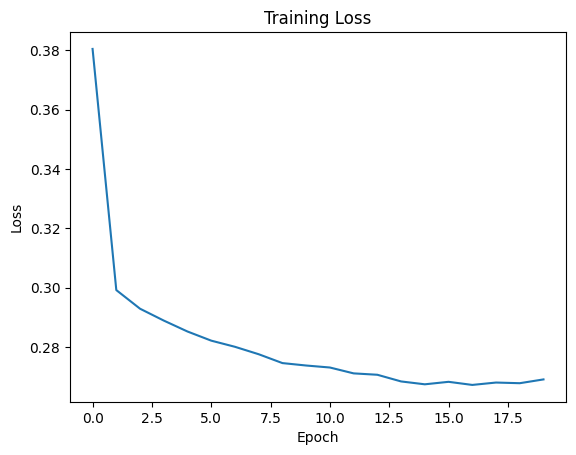

In [13]:
%matplotlib inline

loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_plot(loss_per_epoch, "Training Loss", "Epoch", "Loss")

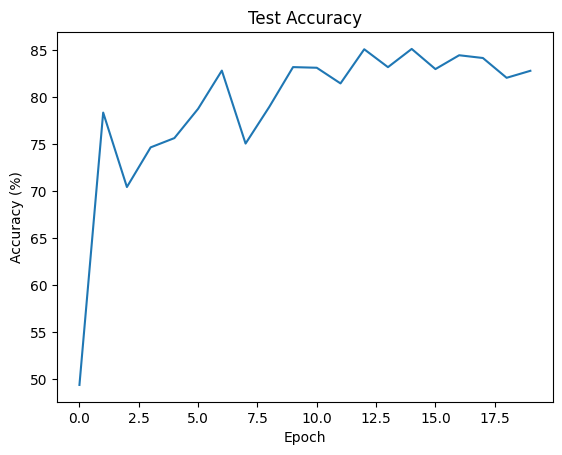

In [14]:
%matplotlib inline

acc_per_epoch = [100*np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
display_plot(acc_per_epoch, "Test Accuracy", "Epoch", "Accuracy (%)")

In [15]:
print(f"Final model test accuracy = {100*test(model, test_loader, device):.4f}%")

Final model test accuracy = 85.1426%


### Improving the model

There are many things that can be done for improving the model's accuracy. Strategies such as making the model larger, trying a different combination of features, changing model topology, etc can all influence the outcome, where domain expertise can also play a significant role. This exercise is left for the network machine learning engineer to experiment with.

For now, we simply save the model into our build directory for part one, and end this first notebook in the series. In part 2, we will use this trained model checkpoint and perform "surgery" on it to prepare it for the FINN framework. 

In [16]:
save_model_to = join(BUILD_DIR, "trained_model.pth")
torch.save(model.state_dict(), save_model_to)

# save the dataset_metadata as well for future use
with open(join(BUILD_DIR, "dataset_metadata.json"), "w") as fp:
    json.dump(dataset_metadata, fp, indent=4)